In [145]:
from src.match3 import *
from src.utils import InputEmbedCausalTransformer
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
import json
import numpy as np
import os 
import pandas as pd
import random
import torch
import torch.nn.functional as F
import pickle
import matplotlib.pyplot as plt

In [2]:
MODEL_PATH = "/home/loki/projects/filler_tokens/output_dir/2024-08-14-22-matchdata-checkpoint-final/model_weights.pt"
CONFIG_FILE = "/home/loki/projects/filler_tokens/misc/llama_d384l4h6.json"

In [3]:
# train_df = pd.read_csv('data/matchdata_trainset_2024-08-13.csv', header=None, names=["text"])
# train_set = Match3VectorDataset(train_df, 3, 10, 10, 'P')

In [4]:
test_df = pd.read_csv('data/matchdata_testset_2024-08-13.csv', header=None, names=["text"])
test_set = Match3VectorDataset(test_df, 3, 10, 10, 'P')
print(test_set.input_dim)

validate encodings
raw input 0  433 450 421 129 107 924 489 711 540 034 P 0- 3 0- 4 3- 2 4- 0 5- 5 0- 8 7- 1 0- 7 9- 4 1- 8 3- 5 1- 7 1- 3 6- 8 1- 1 8- 9 9- 4 3- 5 4- 2 5- 5 6- 8 2- 2 2- 6 9- 5 3- 2 5- 0 6- 5 3- 0 8- 9 9- 5 4- 2 6- 8 7- 1 8- 4 4- 3 6- 3 5- 6 8- 4 9- 8 7- 9 8- 9 6- 1 7- 2 7- 7 9- 7 9- 5 A False
encoded sample 0 {'input_ids': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float16), 'labels': tensor([-100, -100, -100, -100, -100, -100, -100, -100, -100, -100,    5,   28,
           5,   29,    8,   27,    9,   25,   10,   30,    5,   33,   12,   26,
           5,   32,   14,   29,    6,   33,    8,   30,    6,   32,    6,   28,
          11,   33,    6,   26,   13,   34,   14,   29,    8,   30,    9,   27,
          10,   30,   11,   33,    7,   27,    7,  

In [5]:
class BlockOutputWrapper(torch.nn.Module):
    def __init__(self, block, unembed_matrix, norm):
        super().__init__()
        self.block = block
        self.unembed_matrix = unembed_matrix
        self.norm = norm
        self.block_output_unembedded = None

    def forward(self, *args, **kwargs):
        output = self.block(*args, **kwargs)
        if isinstance(output, tuple):
            self.block_output_unembedded = self.unembed_matrix(self.norm(output[0]))
            return output
        else:
            self.block_output_unembedded = self.unembed_matrix(self.norm(output))
            return output

    def reset_block_output(self):
        self.block_output_unembedded = None

class LlamaHelper:
    def __init__(self, config_file, model_path, test_set):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        config = AutoConfig.from_pretrained(config_file)
        model = InputEmbedCausalTransformer(AutoModelForCausalLM.from_config(config), test_set.input_dim)
        state_dict = torch.load(model_path)
        model.load_state_dict(state_dict, strict=False)
        model = model.to(self.device)
        self.model = model
        self.word_index_map = test_set.word_index_map
        self.data_len = test_set.data_len
        self.mod = test_set.mod
        self.input_dim = test_set.input_dim
        
        for i, layer in enumerate(self.model.base_model.model.layers):
            self.model.base_model.model.layers[i] = BlockOutputWrapper(layer, self.model.base_model.lm_head, self.model.base_model.model.norm)

    def decode_tensors(self, sequence):
        decoded_sequence = []
        marker_found = False

        for token in sequence:
            token = token.item()
            if token == -100:
                if not marker_found:
                    decoded_sequence.append("[MASK]")
                continue
            elif token == 0:
                decoded_sequence.append("[EOS]")
                break  # Stop decoding after EOS
            elif token < len(self.word_index_map):
                # Regular word
                word = list(self.word_index_map.keys())[list(self.word_index_map.values()).index(token)]
                decoded_sequence.append(word)
                if word in ["A", "P"]:
                    marker_found = True
            else:
                # Handle digit labels
                offset = len(self.word_index_map)
                if token < offset + self.data_len * 2:
                    # Tuple index encoding
                    idx = (token - offset) % self.data_len
                    tuple_pos = (token - offset) // self.data_len
                    decoded_sequence.append(f"{tuple_pos}-{idx}")
                else:
                    # Single digit or digit in tuple
                    char_pos = (token - offset - self.data_len * 2) // self.mod
                    digit = (token - offset - self.data_len * 2) % self.mod
                    if char_pos == 0 or len(decoded_sequence) == 0 or not decoded_sequence[-1][-1].isdigit():
                        decoded_sequence.append(str(digit))
                    else:
                        decoded_sequence[-1] += str(digit)

        return " ".join(decoded_sequence)


    def set_add_attn_output(self, layer, add_output):
        self.model.base_model.model.layers[layer].attn_add_tensor(add_output)

    def get_attn_activations(self, layer):
        return self.model.base_model.model.layers[layer].get_attn_activations()

    def reset_all_layers(self):
        for layer in self.model.base_model.model.layers:
            layer.reset_block_output()
            
    @staticmethod
    def get_tokens(model, layer_idx, input_ids, decode_tensors, num_layers, rank=1, device="cuda", skip_idx=None, skip_random=False):
        with torch.no_grad():
            outputs = model(input_ids.float().unsqueeze(0))
            logits = outputs.logits

        last_token_logits = logits[0, -1, :]

        if layer_idx < num_layers:
            layer = model.base_model.model.layers[layer_idx]
            if layer.block_output_unembedded is not None:
                last_token_logits = layer.block_output_unembedded[0, -1, :]

        # Get top k values and indices, where k is rank + 1 (to account for potential skip)
        k = rank + 1
        val, idx = torch.topk(last_token_logits, k)

        # If skip_idx is provided, remove it from consideration
        if skip_idx is not None:
            mask = idx != skip_idx
            idx = idx[mask]
            val = val[mask]

        # Select the token at the specified rank (subtracting 1 because rank is 1-indexed)
        
        selected_idx = torch.randint(0, len(idx), (1,)).item() if skip_random else min(rank - 1, len(idx) - 1)

        token = decode_tensors(idx[selected_idx].unsqueeze(-1)).strip()

        return token, idx[selected_idx].item()


    def create_new_token_input(self, token_id):
        new_input = torch.zeros(1, self.input_dim, dtype=torch.float16)
        if token_id < len(self.word_index_map):
            new_input[0, token_id] = 1
        else:
            # Handle digit sequences
            offset = len(self.word_index_map)
            if token_id < offset + self.data_len * 2:
                # Tuple index encoding
                idx = (token_id - offset) % self.data_len
                tuple_pos = (token_id - offset) // self.data_len
                new_input[0, offset + tuple_pos * self.data_len + idx] = 1
            else:
                # Single digit or digit in tuple
                char_pos = (token_id - offset - self.data_len * 2) // self.mod
                digit = (token_id - offset - self.data_len * 2) % self.mod
                new_input[0, offset + self.data_len * 2 + char_pos * self.mod + digit] = 1
        return new_input
    

    def print_logit_progression(self, inputs,
                                max_new_tokens=len(test_set[0]['labels']),
                                layer_number=None,
                                rank=1,
                                skip_idx = None,
                                input_length = None,
                                skip_random = False,
                                is_print=True):
        

        self.reset_all_layers()
        num_layers = len(self.model.base_model.model.layers)
        result_dict = {f"h{i}_out": [] for i in range(num_layers)}
        result_dict["h_out"] = []
        input_ids = inputs['input_ids'].to(self.device)
        if input_length:
            input_ids = input_ids[:input_length]
        generated_sequence = input_ids.clone()

        for _ in range(max_new_tokens):
            self.reset_all_layers()
            
            if layer_number is not None:
                if layer_number > num_layers:
                    print(f"Error: Layer number {layer_number} is out of range. Max layer is {num_layers}.")
                    return {}
                token, token_id = self.get_tokens(self.model, 
                                                  layer_number, 
                                                  generated_sequence, 
                                                  self.decode_tensors, 
                                                  num_layers, 
                                                  rank, 
                                                  self.device, 
                                                  skip_idx,
                                                  skip_random)
                layer_name = f"h{layer_number}_out" if layer_number < num_layers else "h_out"
                result_dict[layer_name].append(token)
            else:
                for i in range(num_layers + 1):
                    token, token_id = self.get_tokens(self.model, 
                                                      i, 
                                                      generated_sequence, 
                                                      self.decode_tensors, 
                                                      num_layers, 
                                                      rank, 
                                                      self.device, 
                                                      skip_idx,
                                                      skip_random)
                    layer_name = f"h{i}_out" if i < num_layers else "h_out"
                    result_dict[layer_name].append(token)
                    
            if token in ["[EOS]","True","False"]: break

            try:
                new_token_input = self.create_new_token_input(token_id).to(self.device)
                    
                generated_sequence = torch.cat([generated_sequence, new_token_input], dim=0)
            except:
                generated_sequence = torch.cat([generated_sequence], dim=0)
                break


        # Print results
        if is_print:
            if layer_number is not None:
                layer_name = f"h{layer_number}_out" if layer_number < num_layers else "h_out"
                print(f"{rank}th highest logit for {layer_name}:")
                print(" ".join(result_dict[layer_name]))
            else:
                print(f"{rank}th highest logit:")
                for layer_name, tokens in result_dict.items():
                    print(f"{layer_name:<5}: " + " ".join(tokens))

        return result_dict
    
    def get_layer_logits(self, inputs, layer_idx):
        self.reset_all_layers()
        num_layers = len(self.model.base_model.model.layers)
        
        if layer_idx > num_layers:
            raise ValueError(f"Error: Layer number {layer_idx} is out of range. Max layer is {num_layers}.")
        
        input_ids = inputs['input_ids'].to(self.device)
        
        with torch.no_grad():
            outputs = self.model(input_ids.float().unsqueeze(0))
            logits = outputs.logits
        
        if layer_idx < num_layers:
            layer = self.model.base_model.model.layers[layer_idx]
            if layer.block_output_unembedded is not None:
                logits = layer.block_output_unembedded
        
        return logits


In [6]:
model = LlamaHelper(CONFIG_FILE, MODEL_PATH, test_set)

In [7]:
model.print_logit_progression(test_set[500], rank=1,layer_number=None, input_length=11)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


1th highest logit:
h0_out: . [EOS] A 9 3 A [EOS] A A 4 A [EOS] 0 6 2 1 7 4 A A 1 1 3 3 3 A 4 6 6 6 9 3 4 4 4 4 [EOS] [EOS] [EOS] [EOS] 3 . . 6 [EOS] [EOS] 3 9 9 [EOS] A A A 0-2 0 [EOS] [EOS] 4 4 [EOS] [EOS] [EOS] [EOS] 7 7 4 0 [EOS] [EOS] [EOS] [EOS] 5 4 A 6 [EOS] [EOS] [EOS] [EOS] 0 1 [EOS] [EOS] [EOS] [EOS] A 4 [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] 0 0 [EOS] [EOS] [EOS]
h1_out: . 8 A 5 8 8 4 0 3 3 2 2 A A 3 3 2 2 A A 2 3 2 2 2 A A A A A 0 2 2 A 2 A 6 6 2 2 A 5 5 A A 3 A 0 A 9 A A A A 7 3 8 2 5 A A A A 6 4 4 4 A A A A A A A 4 4 A A 9 9 A 2 2 2 A A A 5 5 A A [EOS] [EOS] [EOS] [EOS] A A A A A [EOS] False
h2_out: . . . . 0-7 True 4 . . . [EOS] . A . . . . . . . . . . . . A A 6 3 A . . . . . . . . . . A . . . . . A A True . . . 0-9 0-9 . . . . . . . . A . [EOS] . . A A A . . A A [EOS] [EOS] . 6 . . . . . . A A . . . A [EOS] [EOS] [EOS] [EOS] [EOS] A . . . [EOS] [EOS] False
h3_out: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

{'h0_out': ['.',
  '[EOS]',
  'A',
  '9',
  '3',
  'A',
  '[EOS]',
  'A',
  'A',
  '4',
  'A',
  '[EOS]',
  '0',
  '6',
  '2',
  '1',
  '7',
  '4',
  'A',
  'A',
  '1',
  '1',
  '3',
  '3',
  '3',
  'A',
  '4',
  '6',
  '6',
  '6',
  '9',
  '3',
  '4',
  '4',
  '4',
  '4',
  '[EOS]',
  '[EOS]',
  '[EOS]',
  '[EOS]',
  '3',
  '.',
  '.',
  '6',
  '[EOS]',
  '[EOS]',
  '3',
  '9',
  '9',
  '[EOS]',
  'A',
  'A',
  'A',
  '0-2',
  '0',
  '[EOS]',
  '[EOS]',
  '4',
  '4',
  '[EOS]',
  '[EOS]',
  '[EOS]',
  '[EOS]',
  '7',
  '7',
  '4',
  '0',
  '[EOS]',
  '[EOS]',
  '[EOS]',
  '[EOS]',
  '5',
  '4',
  'A',
  '6',
  '[EOS]',
  '[EOS]',
  '[EOS]',
  '[EOS]',
  '0',
  '1',
  '[EOS]',
  '[EOS]',
  '[EOS]',
  '[EOS]',
  'A',
  '4',
  '[EOS]',
  '[EOS]',
  '[EOS]',
  '[EOS]',
  '[EOS]',
  '[EOS]',
  '[EOS]',
  '[EOS]',
  '[EOS]',
  '[EOS]',
  '0',
  '0',
  '[EOS]',
  '[EOS]',
  '[EOS]'],
 'h1_out': ['.',
  '8',
  'A',
  '5',
  '8',
  '8',
  '4',
  '0',
  '3',
  '3',
  '2',
  '2',
  'A',
  'A',
 

In [8]:
model.print_logit_progression(test_set[500], rank=2,layer_number=None, input_length=11)

2th highest logit:
h0_out: 0-0 2 [EOS] 0-2 A 5 A 2 A 0-8 A 3 [EOS] 9 0-2 4 4 5 0-6 5 0-2 5 3 2 0-8 2 A 9 1 9 0-5 5 0-8 6 0-7 3 0-9 0-8 2 0-6 0-6 9 [EOS] 9 0-2 0 0-5 0 [EOS] [EOS] [EOS] 2 0-6 2 0-7 5 0-6 0 A 5 [EOS] 1 0-6 2 0-4 5 0-7 . [EOS] 5 A 6 A 7 0-6 6 0 6 0-6 5 0-6 2 0-6 5 0-6 5 0-7 1 [EOS] 4 0-6 0-2 0-6
h1_out: 0-0 9 0-2 9 0-2 1 0-2 1 0-2 6 0-2 1 0-2 5 0-2 8 0-2 7 0-2 4 0-2 6 0-2 9 0-2 4 0-6 8 0-2 2 0-9 6 0-9 0 0-7 4 0-7 6 0-7 2 0-6 6 0-2 1 0-6 7 0-2 8 0-7 8 0-7 4 0-6 3 0-9 3 0-7 9 0-7 0 0-7 8 0-6 0 0-9 3 0-7 8 0-9 5 0-7 0 0-9 2 0-6 4 0-7 6 0-7 3 0-6 1 0-7 9 0-7 9 0-6 8 0-9 7 0-7 7 0-7
h2_out: 0-1 9 0-2 9 0-3 1 0-4 2 0-5 6 0-6 0 0-7 9 0-8 8 0-0 7 0-2 7 0-3 6 0-4 2 0-5 4 0-1 8 0-7 2 0-8 5 0-9 1 0-3 6 0-2 6 0-5 1 [EOS] 5 0-7 1 0-2 7 0-2 8 A 8 0-5 2 0-3 7 0-7 3 0-3 9 0-3 4 0-4 0 0-4 2 0-7 3 [EOS] 6 0-4 0 0-5 2 0-7 2 0-8 5 0-5 5 0-7 3 0-8 1 0-6 0 [EOS] 7 0-7 5 0-8 7 0-3 4 0-4
h3_out: 0-0 9 0-0 9 0-0 1 0-4 2 0-0 1 0-0 1 0-0 5 0-8 8 0-0 7 0-1 0 0-1 6 0-1 0-5 0-5 4 0-1 2 0-1 2 0-1 3 0-9

{'h0_out': ['0-0',
  '2',
  '[EOS]',
  '0-2',
  'A',
  '5',
  'A',
  '2',
  'A',
  '0-8',
  'A',
  '3',
  '[EOS]',
  '9',
  '0-2',
  '4',
  '4',
  '5',
  '0-6',
  '5',
  '0-2',
  '5',
  '3',
  '2',
  '0-8',
  '2',
  'A',
  '9',
  '1',
  '9',
  '0-5',
  '5',
  '0-8',
  '6',
  '0-7',
  '3',
  '0-9',
  '0-8',
  '2',
  '0-6',
  '0-6',
  '9',
  '[EOS]',
  '9',
  '0-2',
  '0',
  '0-5',
  '0',
  '[EOS]',
  '[EOS]',
  '[EOS]',
  '2',
  '0-6',
  '2',
  '0-7',
  '5',
  '0-6',
  '0',
  'A',
  '5',
  '[EOS]',
  '1',
  '0-6',
  '2',
  '0-4',
  '5',
  '0-7',
  '.',
  '[EOS]',
  '5',
  'A',
  '6',
  'A',
  '7',
  '0-6',
  '6',
  '0',
  '6',
  '0-6',
  '5',
  '0-6',
  '2',
  '0-6',
  '5',
  '0-6',
  '5',
  '0-7',
  '1',
  '[EOS]',
  '4',
  '0-6',
  '0-2',
  '0-6'],
 'h1_out': ['0-0',
  '9',
  '0-2',
  '9',
  '0-2',
  '1',
  '0-2',
  '1',
  '0-2',
  '6',
  '0-2',
  '1',
  '0-2',
  '5',
  '0-2',
  '8',
  '0-2',
  '7',
  '0-2',
  '4',
  '0-2',
  '6',
  '0-2',
  '9',
  '0-2',
  '4',
  '0-6',
  '8',
  '0-2

In [80]:
results_list = []

for idx in tqdm(range(len(test_set))):
    sample = test_set[idx]
    
    # naive 
    h_out = model.print_logit_progression(sample,
                                          rank=1,
                                          layer_number=4, 
                                          input_length=11,
                                          skip_idx = None, 
                                          skip_random = False, 
                                          is_print=False)['h_out']
    
    # modified decoding
    h_out_skip = model.print_logit_progression(sample,
                                               rank=1,
                                               layer_number=4, 
                                               input_length=11, 
                                               skip_idx = 3,
                                               skip_random = False,
                                               is_print=False)['h_out']
    
    # modified + random tokens
    h_out_skip_rnd = model.print_logit_progression(sample, 
                                                   rank=1,
                                                   layer_number=4, 
                                                   input_length=11, 
                                                   skip_idx = 3, 
                                                   skip_random = True, 
                                                   is_print=False)['h_out']
    
    # rank-2
    h_out_rank2 = model.print_logit_progression(sample,
                                          rank=2,
                                          layer_number=4, 
                                          input_length=11,
                                          skip_idx = None, 
                                          skip_random = False, 
                                          is_print=False)['h_out']

    result = {
        "h_out": " ".join(h_out),
        "h_out_skip": " ".join(h_out_skip),
        "h_out_skip_rnd": " ".join(h_out_skip_rnd),
        "h_out_rank2": " ".join(h_out_rank2),
    }
    results_list.append(result)

100%|██████████| 2000/2000 [39:08<00:00,  1.17s/it]


In [10]:
with open('results_list.pkl', 'wb') as f:
    pickle.dump(results_list, f)

### Pictures of layerwise progression of hidden tokens for rank-1 and rank2

In [87]:
model.print_logit_progression(test_set[500], rank=1,layer_number=None, input_length=11)
print("\n\n")

1th highest logit:
h0_out: . [EOS] A 9 3 A [EOS] A A 4 A [EOS] 0 6 2 1 7 4 A A 1 1 3 3 3 A 4 6 6 6 9 3 4 4 4 4 [EOS] [EOS] [EOS] [EOS] 3 . . 6 [EOS] [EOS] 3 9 9 [EOS] A A A 0-2 0 [EOS] [EOS] 4 4 [EOS] [EOS] [EOS] [EOS] 7 7 4 0 [EOS] [EOS] [EOS] [EOS] 5 4 A 6 [EOS] [EOS] [EOS] [EOS] 0 1 [EOS] [EOS] [EOS] [EOS] A 4 [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] 0 0 [EOS] [EOS] [EOS]
h1_out: . 8 A 5 8 8 4 0 3 3 2 2 A A 3 3 2 2 A A 2 3 2 2 2 A A A A A 0 2 2 A 2 A 6 6 2 2 A 5 5 A A 3 A 0 A 9 A A A A 7 3 8 2 5 A A A A 6 4 4 4 A A A A A A A 4 4 A A 9 9 A 2 2 2 A A A 5 5 A A [EOS] [EOS] [EOS] [EOS] A A A A A [EOS] False
h2_out: . . . . 0-7 True 4 . . . [EOS] . A . . . . . . . . . . . . A A 6 3 A . . . . . . . . . . A . . . . . A A True . . . 0-9 0-9 . . . . . . . . A . [EOS] . . A A A . . A A [EOS] [EOS] . 6 . . . . . . A A . . . A [EOS] [EOS] [EOS] [EOS] [EOS] A . . . [EOS] [EOS] False
h3_out: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

In [85]:
model.print_logit_progression(test_set[500], rank=2,layer_number=None, input_length=11)
print("\n\n")

2th highest logit:
h0_out: 0-0 2 [EOS] 0-2 A 5 A 2 A 0-8 A 3 [EOS] 9 0-2 4 4 5 0-6 5 0-2 5 3 2 0-8 2 A 9 1 9 0-5 5 0-8 6 0-7 3 0-9 0-8 2 0-6 0-6 9 [EOS] 9 0-2 0 0-5 0 [EOS] [EOS] [EOS] 2 0-6 2 0-7 5 0-6 0 A 5 [EOS] 1 0-6 2 0-4 5 0-7 . [EOS] 5 A 6 A 7 0-6 6 0 6 0-6 5 0-6 2 0-6 5 0-6 5 0-7 1 [EOS] 4 0-6 0-2 0-6
h1_out: 0-0 9 0-2 9 0-2 1 0-2 1 0-2 6 0-2 1 0-2 5 0-2 8 0-2 7 0-2 4 0-2 6 0-2 9 0-2 4 0-6 8 0-2 2 0-9 6 0-9 0 0-7 4 0-7 6 0-7 2 0-6 6 0-2 1 0-6 7 0-2 8 0-7 8 0-7 4 0-6 3 0-9 3 0-7 9 0-7 0 0-7 8 0-6 0 0-9 3 0-7 8 0-9 5 0-7 0 0-9 2 0-6 4 0-7 6 0-7 3 0-6 1 0-7 9 0-7 9 0-6 8 0-9 7 0-7 7 0-7
h2_out: 0-1 9 0-2 9 0-3 1 0-4 2 0-5 6 0-6 0 0-7 9 0-8 8 0-0 7 0-2 7 0-3 6 0-4 2 0-5 4 0-1 8 0-7 2 0-8 5 0-9 1 0-3 6 0-2 6 0-5 1 [EOS] 5 0-7 1 0-2 7 0-2 8 A 8 0-5 2 0-3 7 0-7 3 0-3 9 0-3 4 0-4 0 0-4 2 0-7 3 [EOS] 6 0-4 0 0-5 2 0-7 2 0-8 5 0-5 5 0-7 3 0-8 1 0-6 0 [EOS] 7 0-7 5 0-8 7 0-3 4 0-4
h3_out: 0-0 9 0-0 9 0-0 1 0-4 2 0-0 1 0-0 1 0-0 5 0-8 8 0-0 7 0-1 0 0-1 6 0-1 0-5 0-5 4 0-1 2 0-1 2 0-1 3 0-9

### Statistics of hidden tokens at each layer

In [118]:
results_rank1_all_layers = []

rnd_idx = sorted(random.sample(range(len(test_set)), len(test_set)//4))

for idx in tqdm(rnd_idx):
    sample = test_set[idx]
    
    # naive 
    logit_seq = model.print_logit_progression(sample,
                                          rank=1,
                                          layer_number=None, 
                                          input_length=11,
                                          skip_idx = None, 
                                          skip_random = False, 
                                          is_print=False)
    result = {}
    for k,v in logit_seq.items(): result[k] = " ".join(v)

    results_rank1_all_layers.append(result)

with open('results_rank1_all_layers.pkl', 'wb') as f:
    pickle.dump(results_rank1_all_layers, f)

100%|██████████| 500/500 [12:32<00:00,  1.50s/it]


In [125]:
len(results_rank1_all_layers[0]['h_out'].split(' '))

102

In [124]:
 sum([token=='.' for token in results_rank1_all_layers[0]['h_out'].split(' ')])

100

In [143]:
hidden_layer_pct = {layer: 0.0 for layer, seq in results_rank1_all_layers[0].items()}

for result in results_rank1_all_layers:
    for layer,seq in result.items():
        hidden_layer_pct[layer] += sum([token=='.' for token in seq.split(" ")])/len(results_rank1_all_layers[0]['h_out'].split(' '))

hidden_layer_pct = {layer: round(count/len(results_rank1_all_layers)*100,3) for layer, count in hidden_layer_pct.items()}

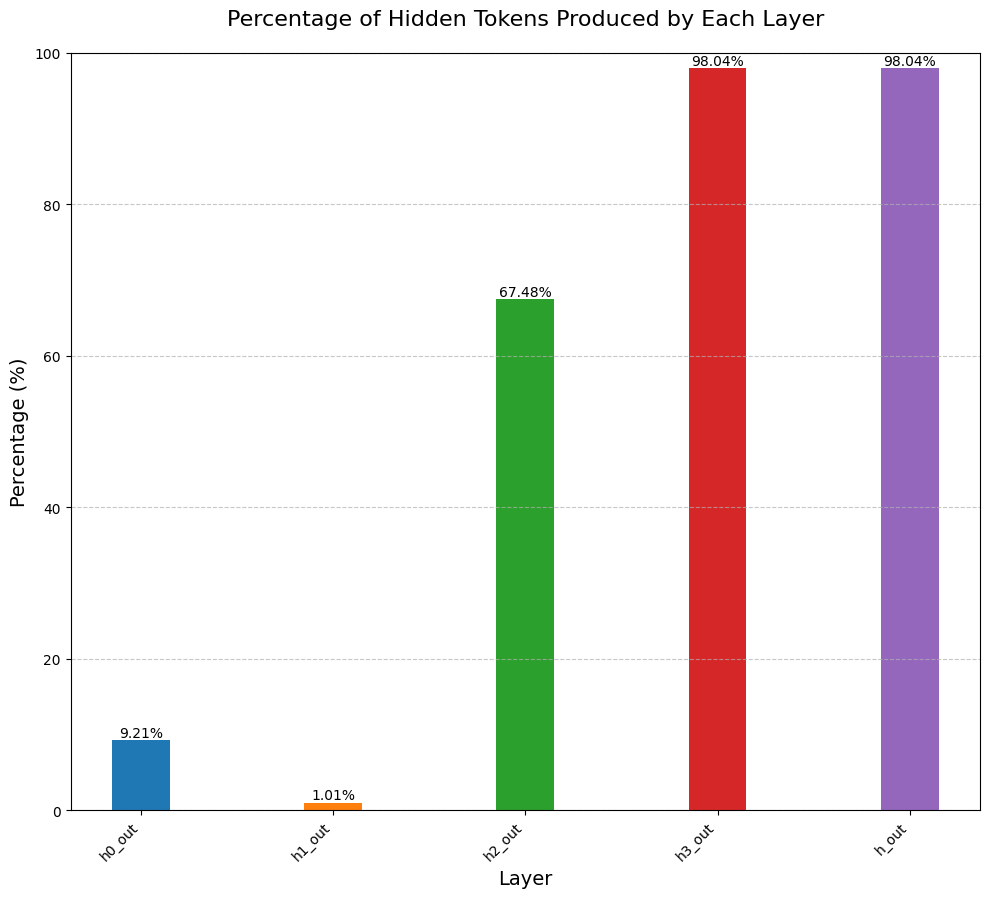

<Figure size 640x480 with 0 Axes>

In [158]:
layers = list(hidden_layer_pct.keys())
percentages = list(hidden_layer_pct.values())

# Create bar plot with thinner bars
plt.figure(figsize=(10, 5))  # Increased figure size for better spacing
bar_width = 0.3  # Adjust this value to make bars thinner or thicker
bars = plt.bar(layers, percentages, width=bar_width, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

# Customize the plot
plt.title('Percentage of Hidden Tokens Produced by Each Layer', fontsize=16, pad=20)  # Added padding to title
plt.xlabel('Layer', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100%

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a grid for easier comparison
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Add extra space at the top
plt.subplots_adjust(top=1.7)

plt.show()

plt.savefig('hidden_tokens_percentage_by_layer.png', dpi=300, bbox_inches='tight')

### Statistics of rank-1 vs rank-2 vs skip vs skip-random final layer responses for True/False

In [ ]:
"h_out_skip": " ".join(h_out_skip),
"h_out_skip_rnd": " ".join(h_out_skip_rnd),
"h_out_rank2": " ".join(h_out_rank2),


In [98]:
rank1_skip_match_pct = sum([(results_list[idx]['h_out'].split(" ")[-1] == results_list[idx]['h_out_skip'].split(" ")[-1]) for idx in range(len(results_list))])*100/len(results_list)
print(f"Percentage of sequences where the answer of rank-1 tokens is same as skip tokens is: {rank1_skip_match_pct}%")

rank1_h_out_rank2_match_pct = sum([(results_list[idx]['h_out'].split(" ")[-1] == results_list[idx]['h_out_skip_rnd'].split(" ")[-1]) for idx in range(len(results_list))])*100/len(results_list)
print(f"Percentage of sequences where the answer of rank-1 tokens is same as skip-random tokens is: {rank1_h_out_rank2_match_pct}%")

rank1_rank2_match_pct = sum([(results_list[idx]['h_out'].split(" ")[-1] == results_list[idx]['h_out_rank2'].split(" ")[-1]) for idx in range(len(results_list))])*100/len(results_list)
print(f"Percentage of sequences where the answer of rank-1 tokens is same as rank-2 tokens is: {rank1_rank2_match_pct}%")

Percentage of sequences where the answer of rank-1 tokens is same as skip tokens is: 100.0%
Percentage of sequences where the answer of rank-1 tokens is same as skip-random tokens is: 39.85%
Percentage of sequences where the answer of rank-1 tokens is same as rank-2 tokens is: 2.4%


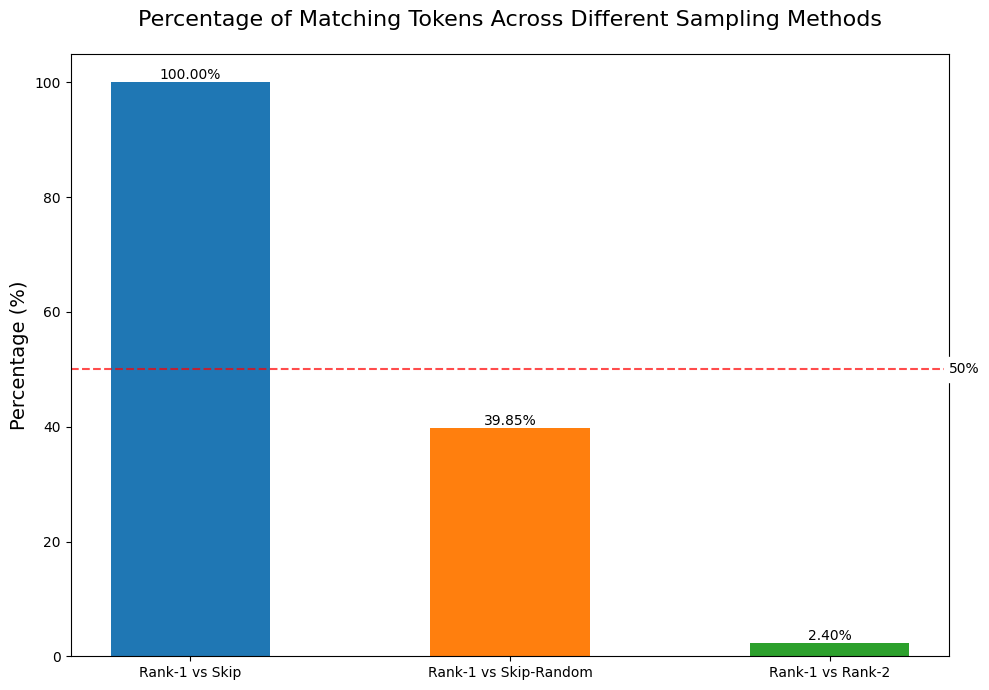

<Figure size 640x480 with 0 Axes>

In [114]:


# Calculate percentages
rank1_skip_match_pct = sum([(results_list[idx]['h_out'].split(" ")[-1] == results_list[idx]['h_out_skip'].split(" ")[-1]) for idx in range(len(results_list))])*100/len(results_list)
rank1_h_out_rank2_match_pct = sum([(results_list[idx]['h_out'].split(" ")[-1] == results_list[idx]['h_out_skip_rnd'].split(" ")[-1]) for idx in range(len(results_list))])*100/len(results_list)
rank1_rank2_match_pct = sum([(results_list[idx]['h_out'].split(" ")[-1] == results_list[idx]['h_out_rank2'].split(" ")[-1]) for idx in range(len(results_list))])*100/len(results_list)

# Data for plotting
categories = ['Rank-1 vs Skip', 'Rank-1 vs Skip-Random', 'Rank-1 vs Rank-2']
percentages = [rank1_skip_match_pct, rank1_h_out_rank2_match_pct, rank1_rank2_match_pct]

# Create bar plot with thinner bars and adjusted layout
plt.figure(figsize=(10, 7))  # Increased figure height
bar_width = 0.5
bars = plt.bar(categories, percentages, width=bar_width, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

# Customize the plot
plt.title('Percentage of Matching Tokens Across Different Sampling Methods', fontsize=16, pad=20)  # Added padding
plt.ylabel('Percentage (%)', fontsize=14)
plt.ylim(0, 105)  # Increased y-axis limit to create more space at the top

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom')

# Add a horizontal line at 50% for reference
plt.axhline(y=50, color='r', linestyle='--', alpha=0.7)
plt.text(plt.xlim()[1], 50, '50%', va='center', ha='left', backgroundcolor='w')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

plt.savefig('token_comparison_percentages.png', dpi=300, bbox_inches='tight')

### Comparison of output sequences of various sampling methods

In [109]:
model.print_logit_progression(test_set[500], rank=1,layer_number=None, input_length=11)
print("\n\n")

1th highest logit:
h0_out: . [EOS] A 9 3 A [EOS] A A 4 A [EOS] 0 6 2 1 7 4 A A 1 1 3 3 3 A 4 6 6 6 9 3 4 4 4 4 [EOS] [EOS] [EOS] [EOS] 3 . . 6 [EOS] [EOS] 3 9 9 [EOS] A A A 0-2 0 [EOS] [EOS] 4 4 [EOS] [EOS] [EOS] [EOS] 7 7 4 0 [EOS] [EOS] [EOS] [EOS] 5 4 A 6 [EOS] [EOS] [EOS] [EOS] 0 1 [EOS] [EOS] [EOS] [EOS] A 4 [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] 0 0 [EOS] [EOS] [EOS]
h1_out: . 8 A 5 8 8 4 0 3 3 2 2 A A 3 3 2 2 A A 2 3 2 2 2 A A A A A 0 2 2 A 2 A 6 6 2 2 A 5 5 A A 3 A 0 A 9 A A A A 7 3 8 2 5 A A A A 6 4 4 4 A A A A A A A 4 4 A A 9 9 A 2 2 2 A A A 5 5 A A [EOS] [EOS] [EOS] [EOS] A A A A A [EOS] False
h2_out: . . . . 0-7 True 4 . . . [EOS] . A . . . . . . . . . . . . A A 6 3 A . . . . . . . . . . A . . . . . A A True . . . 0-9 0-9 . . . . . . . . A . [EOS] . . A A A . . A A [EOS] [EOS] . 6 . . . . . . A A . . . A [EOS] [EOS] [EOS] [EOS] [EOS] A . . . [EOS] [EOS] False
h3_out: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

In [110]:
model.print_logit_progression(test_set[500], rank=2,layer_number=None, input_length=11)
print("\n\n")

2th highest logit:
h0_out: 0-0 2 [EOS] 0-2 A 5 A 2 A 0-8 A 3 [EOS] 9 0-2 4 4 5 0-6 5 0-2 5 3 2 0-8 2 A 9 1 9 0-5 5 0-8 6 0-7 3 0-9 0-8 2 0-6 0-6 9 [EOS] 9 0-2 0 0-5 0 [EOS] [EOS] [EOS] 2 0-6 2 0-7 5 0-6 0 A 5 [EOS] 1 0-6 2 0-4 5 0-7 . [EOS] 5 A 6 A 7 0-6 6 0 6 0-6 5 0-6 2 0-6 5 0-6 5 0-7 1 [EOS] 4 0-6 0-2 0-6
h1_out: 0-0 9 0-2 9 0-2 1 0-2 1 0-2 6 0-2 1 0-2 5 0-2 8 0-2 7 0-2 4 0-2 6 0-2 9 0-2 4 0-6 8 0-2 2 0-9 6 0-9 0 0-7 4 0-7 6 0-7 2 0-6 6 0-2 1 0-6 7 0-2 8 0-7 8 0-7 4 0-6 3 0-9 3 0-7 9 0-7 0 0-7 8 0-6 0 0-9 3 0-7 8 0-9 5 0-7 0 0-9 2 0-6 4 0-7 6 0-7 3 0-6 1 0-7 9 0-7 9 0-6 8 0-9 7 0-7 7 0-7
h2_out: 0-1 9 0-2 9 0-3 1 0-4 2 0-5 6 0-6 0 0-7 9 0-8 8 0-0 7 0-2 7 0-3 6 0-4 2 0-5 4 0-1 8 0-7 2 0-8 5 0-9 1 0-3 6 0-2 6 0-5 1 [EOS] 5 0-7 1 0-2 7 0-2 8 A 8 0-5 2 0-3 7 0-7 3 0-3 9 0-3 4 0-4 0 0-4 2 0-7 3 [EOS] 6 0-4 0 0-5 2 0-7 2 0-8 5 0-5 5 0-7 3 0-8 1 0-6 0 [EOS] 7 0-7 5 0-8 7 0-3 4 0-4
h3_out: 0-0 9 0-0 9 0-0 1 0-4 2 0-0 1 0-0 1 0-0 5 0-8 8 0-0 7 0-1 0 0-1 6 0-1 0-5 0-5 4 0-1 2 0-1 2 0-1 3 0-9

In [111]:
model.print_logit_progression(test_set[500], rank=1,layer_number=None, input_length=11, skip_idx=3)
print("\n\n")

1th highest logit:
h0_out: 0-0 5 [EOS] [EOS] [EOS] [EOS] [EOS] 6 A [EOS] [EOS] 0 A [EOS] 0-9 5 [EOS] [EOS] A 3 0-7 3 0-8 2 [EOS] 0-8 A 7 True True 0-6 [EOS] 0-6 0-8 0-6 2 [EOS] [EOS] [EOS] 2 0-6 9 0-6 5 0-6 0-8 0-6 2 A [EOS] [EOS] 2 0-6 6 A 6 [EOS] [EOS] [EOS] [EOS] [EOS] 5 [EOS] 0 [EOS] 2 [EOS] True [EOS] [EOS] A 0-8 A 5 [EOS] [EOS] [EOS] [EOS] A 5 A 1 A [EOS] A 6 0-7 [EOS] [EOS] [EOS] [EOS] [EOS] [EOS] [EOS]
h1_out: 0-0 2 0-0 3 [EOS] 5 0-0 2 0-0 7 0-0 0 0-0 9 0-0 5 0-0 3 0-0 0 0-7 2 0-7 4 [EOS] 8 0-2 8 0-2 0 0-6 5 0-8 8 0-2 0 0-2 1 0-2 0 0-6 1 0-7 4 0-6 0 0-7 2 0-6 3 0-6 2 0-7 8 0-7 6 0-6 2 0-6 4 0-6 9 0-7 2 0-7 2 0-9 6 0-7 0 0-7 9 0-7 8 0-6 5 0-9 5 0-6 2 0-6 8 0-6 0 0-6 6 0-7 5 0-7 4 0-9 4 0-6 False
h2_out: 0-1 1 0-0 3 0-0 5 0-0 1 0-0 1 0-0 1 0-0 5 0-0 5 0-9 3 0-1 0 0-1 2 0-1 0-9 0-1 8 0-6 9 0-1 0 0-1 3 0-9 8 0-2 0 0-4 1 0-2 1 0-6 1 0-2 4 0-8 0 0-9 2 0-4 3 0-3 3 0-6 8 0-3 6 0-8 2 0-9 0 A 8 0-6 0 0-4 2 0-4 8 0-9 1 0-6 0 0-5 8 0-5 4 0-9 0 0-6 2 0-6 8 0-9 1 A 6 0-9 8 0-9 4 0-9 4 A A
h3

In [119]:
model.print_logit_progression(test_set[500], rank=1,layer_number=None, input_length=11,skip_idx = 3, skip_random=True)
print("\n\n")

1th highest logit:
h0_out: 0-0 2 0-6 0-2 A [EOS] [EOS] 2 A [EOS] [EOS] 3 [EOS] 6 0-2 5 [EOS] 5 0-6 5 0-7 5 3 2 [EOS] 0-8 [EOS] 7 8 9 0-5 [EOS] 0-6 0-8 0-6 3 [EOS] [EOS] [EOS] 2 [EOS] 5 0-7 2 0-7 0 [EOS] 2 A [EOS] [EOS] 0-8 A 2 0-7 6 [EOS] 5 [EOS] [EOS] A 1 A 0 0-4 2 0-2 True 0-2 [EOS] 0-6 6 A 5 0-6 [EOS] [EOS] 6 0-6 5 A 1 0-6 1 0-6 5 0-7 [EOS] [EOS] 5 0-6 [EOS] [EOS]
h1_out: 0-0 2 0-2 9 0-0 5 0-2 1 0-0 6 0-0 1 0-0 9 0-0 8 0-0 7 0-2 4 0-7 2 0-7 9 [EOS] 8 0-6 8 0-2 0 0-9 6 0-8 8 0-7 4 0-7 1 0-2 2 0-7 1 0-7 1 0-6 0 0-7 8 0-6 8 0-6 4 0-7 8 0-9 3 0-6 2 0-7 0 0-7 9 0-7 0 0-9 3 0-7 8 0-7 5 0-7 0 0-7 8 0-9 4 0-9 5 0-7 3 0-6 1 0-9 9 0-7 6 0-7 8 0-9 4 0-9 4 0-7
h2_out: 0-1 1 0-2 9 0-0 1 0-4 2 0-0 1 0-6 1 0-7 5 0-0 8 0-0 7 0-1 0 0-3 6 0-1 0-9 0-5 4 0-6 8 0-1 0 0-8 3 0-1 8 0-3 0 0-2 6 0-5 0 [EOS] 1 0-7 4 0-8 7 0-2 8 0-4 8 0-5 3 0-6 7 0-7 6 0-8 2 0-3 4 A 0 0-4 0 0-7 3 0-4 7 0-4 1 0-6 2 0-7 2 0-5 5 0-9 6 0-7 3 0-6 8 0-6 1 A 6 0-9 8 0-8 7 0-3 4 A
h3_out: 0-0 1 0-2 3 0-3 1 0-4 2 0-5 1 0-6 2 0-7 9 0-0 